CNN은 시각 분야에 국한되지 않고, 음성 인식이나 자연어 처리 같은 다른 작업에도 많이 사용된다.

CNN의 가장 중요한 구성 요소는 **합성곱 층**이다. 합성곱 층의 뉴런의 이전 층의 특성맵들의 모든 픽셀에 연결되는 것이 아니라, 수용장 안에 있는 픽셀들에만 연결된다.

아래층에서는 작은 저수준 특성에 집중하고, 그 다음 층에서는 더 큰 고수준 특성으로 조합해 나가도록 도와준다.

한 수용장과 다음 수용장 사이의 수평 또는 수직 방향 스텝 크기를 **스트라이드**라고 한다.

한 특성맵의 픽셀들은 모두 같은 가중치 세트를 공유한다. 이를 **필터**, 혹은 **커널**이라고 한다. **하나의 필터는 하나의 특성맵**을 만든다. 필터를 수동으로 정의하는 것이 아니다. 경사하강법을 통해 학습된다.

필터는 이전 층에 있는 모든 특성 맵에 걸쳐서 확장된다. **이전 층에 채널 수에 대응되는 3차원 행렬을 가지는 것이다.**

한 특성맵에 있는 모든 뉴런이 같은 파라미터를 공유하기 때문에, 모델의 전체 파라미터 수가 급격하게 줄어든다. **일단 CNN이 한 지점에서 패턴을 인식하게 학습되었다면 어떤 위치에 있는 패턴도 인식할 수 있다.**

# 합성곱 층

몇개의 이미지 샘플을 로드하고, CenterCrop과 Rescaling 층으로 전처리 한다.

In [1]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255)(images)

/Users/barrett11357/coding/pycharm/handson_ml_--/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
2025-02-16 18:30:00.719432: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-02-16 18:30:00.719457: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-16 18:30:00.719462: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1739698200.719660 1821397 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1739698200.719830 1821397 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: 

In [2]:
images.shape

TensorShape([2, 70, 120, 3])

출력으로 4D 텐서가 나온다. [샘플수, 가로, 세로, 채널] 구성이다.

2D 합성곱 층을 통과시킨 다음에 출력 shape를 보자.

In [3]:
conv_layer = tf.keras.layers.Conv2D(filters=32, strides=1, padding="same", kernel_size=3)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 70, 120, 32])

스트라이드는 1, 패딩은 same을 사용해서 가로 세로 크기는 똑같이 나왔다. 그리고 필터를 32개를 사용했기 때문에 32개의 특성맵이 생성되어서 32채널로 출력되었다.

`same` 패딩은 출력 특성맵이 입력과 같은 크기가 되도록 입력 가장자리에 충분한 패딩을 추가해준다.

`valid` 패딩은 그냥 패딩을 사용하지 않음. 그래서 출력 특성맵의 크기가 줄어든다.


Conv2D 층의 가중치와 편향을 확인해보자.

In [4]:
kernels, biases = conv_layer.get_weights()
print(kernels.shape)
print(biases.shape)

(3, 3, 3, 32)
(32,)


가중치는 (3, 3, 3, 32) 이렇게 4D 텐서가 나온다. 하나의 커널은 3*3*3 크기이고, 이런 커널이 32개가 있다.

편향은 (32,) 이렇게 1D 텐서가 나온다. 커널마다 하나의 편향을 가지고 있다.



# 풀링

다이 층의 목적은 계산량과 메모리사용량, 파라미터 수를 줄이기 위해 입력 이미지의 부표본을 만드는 것이다.

합성곱 층과 마찬가지로 풀링 층의 각 뉴런은 이전 층의 작은 사각 영역의 수용장 안에 있는 뉴런의 출력과 연결되어 있다. 이전과 동일하게 크기, 스트라이드, 패딩 유형을 지정해야 한다. 하지만 풀링 뉴런은 가중치가 없다. 즉, 최대나 평균 같은 합산 함수를 사용해 입력값을 더하는 것이 전부이다.

아주 널리 사용되는 **최대 풀링층**의 경우 각 수용장에서 가장 큰 입력값이 다음 층으로 전달되고, 다른 값은 버려진다.

위에서 말한 장점 외에도 최대 풀링은 작은 변화에도 일정 수준의 **불변성**을 만들어준다. CNN에서 몇 개 층마다 최대 풀링 층을 추가하면 전체적으로 일정 수준의 이동 불변성을 얻을 수 있다고 한다. 또한 회전과 확대, 축소에 대해서도 약간의 불변성을 제공한다고 한다.

최대 풀링은 단점도 가지고 있는데, 이 층은 매우 파괴적이다. 예를 들어서 커널사이즈가 2이고, 스트라이드 2라면, 면적인 1/4로 줄어든다. 어떤 애플리케이션에는 불변성이 필요하지 않다. **시맨틱 세그멘테이션**의 경우이다. 이 경우 불변성이 아니라 **등변성**이 목표가 된다.

In [5]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="same")

그냥 이렇게 쓰면 된다. 평균 풀링보다 최대 풀링의 성능이 더 좋아서 대부분 최대 풀링층을 사용한다고 한다.

## 깊이 방향 풀링층

흔하지는 않지만 최대, 평균 풀링은 공간 방향이 아닌, **깊이 방향**으로도 수행될 수 있다고 한다. 이를 통해 **CNN이 다양한 특성에 대한 불변성을 학습**할 수 있다고 한다.

예를 들어서 동일 패턴이 회전된 여러 가지 필터를 학습했을 때 회전에 상관없이 동일한 출력을 만든다고 한다.

공간방향 풀링은 이전 층 특성맵들의 가로세로 크기는 줄이지만 차원은 그대로 유지, **깊이방향 풀링은 이전 층 특성맵들의 가로세로 크기는 그대로 유지하지만 차원을 줄이는 것**이다.

케라스가 깊이 방향 풀링 층을 제공하지는 않지만 사용자 정의 층으로 어렵지 않게 구현할 수 있다.

In [6]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        # 층 초기화: pool_size와 추가 인자들을 받아 초기화합니다.
        # pool_size: 깊이(채널) 방향으로 몇 개의 채널을 하나로 합칠지 결정합니다.
        super().__init__(**kwargs)  # 부모 클래스(tf.keras.layers.Layer)의 초기화 메서드를 호출합니다.
        self.pool_size = pool_size  # 전달받은 pool_size 값을 인스턴스 변수에 저장합니다.

    def call(self, inputs):
        # call 메서드는 입력 데이터를 받아 층의 연산을 수행합니다.
        # inputs: 보통 (batch, height, width, channels) 형태의 텐서입니다.

        # 1. 입력 텐서의 동적 shape을 얻습니다.
        shape = tf.shape(inputs)
        # shape는 텐서의 각 차원의 크기를 나타내는 텐서입니다.

        # 2. 깊이 방향 풀링을 위해 채널 수를 그룹으로 나눕니다.
        # shape[-1]은 입력 텐서의 채널 수입니다.
        # pool_size로 나누어 몇 개의 그룹이 생기는지 계산합니다.
        groups = shape[-1] // self.pool_size

        # 3. 텐서의 shape을 재구성하여 채널 차원을 두 개의 차원(그룹과 그룹 내 채널)으로 분리합니다.
        # 새 shape는 기존의 [batch, height, width]와 새로 추가된 [groups, pool_size]를 합친 형태입니다.
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        # 예시: 원래 shape가 [batch, height, width, channels]였다면,
        # 재구성 후에는 [batch, height, width, groups, pool_size] 형태가 됩니다.

        # 4. 재구성된 텐서에서 마지막 차원(pool_size)에 대해 최대값을 계산하여 풀링을 수행합니다.
        # tf.reduce_max는 지정된 axis에 대해 최대값을 구합니다.
        pooled = tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)
        # 이 연산은 각 그룹 내의 pool_size 개의 채널 중 가장 큰 값을 선택하여 깊이를 축소합니다.

        # 5. 깊이 방향으로 풀링된 결과를 반환합니다.
        return pooled

## 전역 평균 풀링 층

얘는 각 특성 맵의 평균을 계산한다. **특성 맵마다 하나의 숫자를 출력**한다. **매우 파괴적**인 연산이지만 **출력 층 직전에 유용하게** 쓰인다고 한다.

In [7]:
tf.keras.layers.GlobalAveragePooling2D()

<GlobalAveragePooling2D name=global_average_pooling2d, built=True>

# CNN 구조

전형적인 CNN 구조는 합성곱 층을 몇 개 쌓고, 그 다음에 풀링 층을 쌓고, 그 다음에 또 합성곱 층을 몇 개 쌓고, 그 다음에 다시 풀링 층을 쌓는 식이다.

풀링 층 때문에 네트워크를 통과할 수록 이미지는 점점 작아지지만, 합성곱 층 때문에 일반적으로 점점 더 깊어진다. 더 많은 특성앱을 가지게 된다.

맨 위층에는 몇 개의 FC층으로 구성된 피드포워드 신경망이 추가되고, 마지막 층에서 소프트맥스 함수 등으로 클래스 확률을 출력하는 식으로 예측을 출력한다.

합성곱 층에서 너무 큰 커널을 사용하는 것은 흔한 실수라고 한다. 큰 커널을 하나 쓰는 것보다 작은 커널을 여러개 쓰는게 계산량도 더 적고 더 좋은 성능을 냄.

한가지 예외는 첫번째 합성곱 층인데 여기에서는 일반적으로 큰 크기의 커널과 2 이상의 스트라이드를 써서 너무 많은 정보를 잃지 않고 공간 방향 차원을 줄일 수 있다고 한다.

## 간단한 CNN 모델 훈련 - 패션 MNIST

아래 코드는 FashionMNIST 문제를 해결하기 위한 기본적인 CNN모델 코드다.
우선은 이렇게 기본적인 CNN코드를 작성한 다음에, 이걸 skip connection을 사용하는 ResNet 구조로 바꿔보자.

처음에는 책 596페이지에 나오는 모델 코드를 그대로 옮겨서 훈련시켰었는데, 책에서 설명하기로는 92%의 정확도를 달성할 수 있다고 했지민, 막상 내가 해보니까 정확도는 잘 안오르면서 loss만 엄청나게 커지는 문제에 직면함. 모델의 loss가 minimum에 수렴해서 그 근처에서 진동하기 전까지는 loss가 계속 쭉쭉 감소하는게 정상임.

그래서 처음에는 옵티마이저를 sgd에서 adam으로 바꾸고, 학습률을 0.0001로 낮추었음. 그러자 loss가 많이 줄어들기는 했으나, 여전히 정확도는 낮고, 훈련이 반복될 수록 loss가 증가하는건 똑같았음.

이 문제를 해결하기 위해 모델의 구조부터 바꿨음. 컨볼루션 층의 텐서가 relu함수를 통과하기 전에 **batch nomalization층**을 통과하게 했음. 그리고 **지수 기반 스케줄링**방식의 학습률 스케줄 함수를 만들었음. 이렇게 하니까 모델이 아주 빠르게 잘 훈련됨!!!



In [60]:
import tensorflow as tf

# 컨볼루션 + 배치 정규화 + 활성화 블록 정의
def conv_bn(filters, kernel_size=3, input_shape=None):
    layers = []
    conv_params = {
        "filters": filters,
        "kernel_size": kernel_size,
        "padding": "same",
        "kernel_initializer": "he_normal",
        "use_bias": False  # BN를 사용하면 bias가 필요없음
    }
    if input_shape is not None:
        conv_params["input_shape"] = input_shape
    layers.append(tf.keras.layers.Conv2D(**conv_params))
    layers.append(tf.keras.layers.BatchNormalization())
    layers.append(tf.keras.layers.Activation("relu"))
    return layers # 레이어 리스트를 반환

model = tf.keras.models.Sequential([
    # 첫 번째 블록: kernel_size 7
    *conv_bn(64, kernel_size=7, input_shape=[28, 28, 1]), # 레이어 리스트 언패킹
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    # 두 번째 블록: filters 128
    *conv_bn(128),
    *conv_bn(128),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    # 세 번째 블록: filters 256
    *conv_bn(256),
    *conv_bn(256),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Flatten(),

    # Fully-connected block 1
    tf.keras.layers.Dense(128, use_bias=False, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.3),

    # Fully-connected block 2
    tf.keras.layers.Dense(64, use_bias=False, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.3),

    # 출력층
    tf.keras.layers.Dense(10, activation="softmax")
])


모델을 한 번 훈련시켜보자.

In [61]:
# Fashion MNIST 데이터셋 로드
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


In [62]:
# 훈련 데이터와 검증 데이터를 분리
# 훈련 50000, 검증 10000, 테스트 10000
X_valid = X_train[50000:]
y_valid = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

In [63]:
# 처음에 이 부분의 코드를 작성하는데 좀 애를 먹었음. 꼭 Dataset을 사용할 필요는 없지만 챕터13에서 배운걸 써먹고 싶어서 이렇게 작성함.
def preprocess(X, y, buffer_size=10000, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # from_tensor_slices()함수는 이렇게 튜플을 매개변수로 받을 수 있다. 입력과 레이블을 묶을 수 있음.
    dataset = dataset.map(lambda x,y : (x/255,y), num_parallel_calls=tf.data.AUTOTUNE) # 정규화, 입력에는 연산을 하고, 레이블에는 아무것도 하지 않은 채로 다시 튜플로 묶어서 반환한다.
    dataset = dataset.map(lambda x,y : (tf.reshape(x, [28,28,1]),y), num_parallel_calls=tf.data.AUTOTUNE) # num_parallel_calls=tf.data.AUTOTUNE로 설정해서 멀티스레드를 사용
    dataset = dataset.shuffle(buffer_size=buffer_size)
    return dataset.batch(batch_size).prefetch(1)

In [64]:
X_train_dateset = preprocess(X_train, y_train)
X_valid_dataset = preprocess(X_valid, y_valid)

In [65]:
# EarlyStopping 콜백 설정: 3 에포크 동안 개선이 없으면 중지하고 최적의 가중치를 복원
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",         # '검증 손실'을 모니터링
    patience=10,                # 3 에포크 동안 개선이 없으면 중지
    restore_best_weights=True,  # 최상의 가중치로 복원
    verbose=1
)

# 초기 학습률과 감소 스케줄 설정
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9

# 학습률 스케줄 함수, 지수 기반 스케줄링
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

# 옵티마이저 설정, Adam 옵티마이저
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"] # 데이터셋의 클래스 비율이 균등할 것이기 때문에(아마도...?) 지표로 정확도를 선택함.
)

# 모델 훈련
history = model.fit(
    X_train_dateset,
    epochs=50,
    validation_data=X_valid_dataset,
    callbacks=[early_stopping],
    verbose=2
)

# 수정 필요

Epoch 1/50
1563/1563 - 47s - 30ms/step - accuracy: 0.8342 - loss: 0.4962 - val_accuracy: 0.8835 - val_loss: 0.3130
Epoch 2/50
1563/1563 - 43s - 28ms/step - accuracy: 0.8901 - loss: 0.3170 - val_accuracy: 0.9070 - val_loss: 0.2629
Epoch 3/50
1563/1563 - 44s - 28ms/step - accuracy: 0.9072 - loss: 0.2650 - val_accuracy: 0.9098 - val_loss: 0.2416
Epoch 4/50
1563/1563 - 46s - 29ms/step - accuracy: 0.9222 - loss: 0.2236 - val_accuracy: 0.9188 - val_loss: 0.2265
Epoch 5/50
1563/1563 - 48s - 31ms/step - accuracy: 0.9346 - loss: 0.1869 - val_accuracy: 0.9226 - val_loss: 0.2260
Epoch 6/50
1563/1563 - 49s - 31ms/step - accuracy: 0.9447 - loss: 0.1582 - val_accuracy: 0.9256 - val_loss: 0.2161
Epoch 7/50
1563/1563 - 47s - 30ms/step - accuracy: 0.9551 - loss: 0.1257 - val_accuracy: 0.9288 - val_loss: 0.2216
Epoch 8/50
1563/1563 - 44s - 28ms/step - accuracy: 0.9663 - loss: 0.0970 - val_accuracy: 0.9278 - val_loss: 0.2210
Epoch 9/50
1563/1563 - 45s - 29ms/step - accuracy: 0.9732 - loss: 0.0761 - val_a

fit()메서드가 반환한 history객체로 그래프 작성

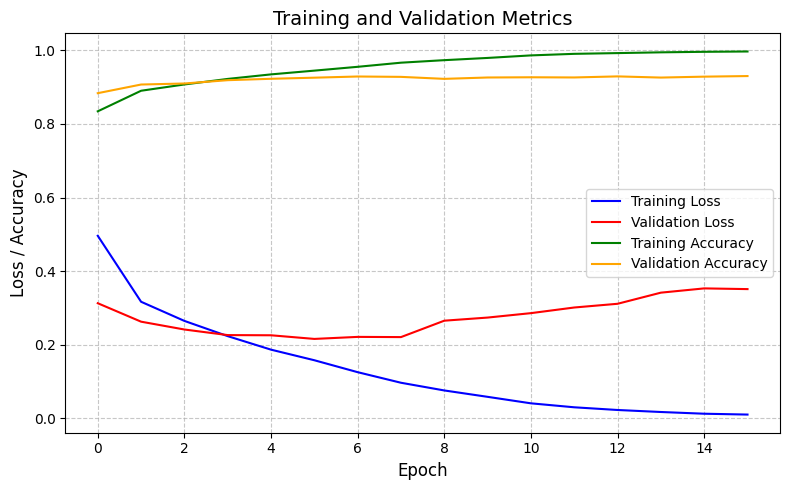

In [68]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.figure(figsize=(8, 5))  # Decreased the figure size

    # Plot all curves on the same chart
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')

    # Customize the chart
    plt.title('Training and Validation Metrics', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss / Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


# Draw the graph
plot_learning_curves(history)

테스트 데이터로 모델 평가, 정확도 92%를 보인다.

In [69]:
X_test_dataset = preprocess(X_test, y_test)
model.evaluate(X_test_dataset)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9219 - loss: 0.2284


[0.2293178290128708, 0.9205999970436096]

모델 저장

In [70]:
model.save("fashion_mnist_cnn.keras")